In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import os, glob, inspect, sys


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Simulated data

This data was simulated based on the observed data. 1000 replicates were drawn from a normal distribution based on the observed mean and standard deviation of features. This analysis is meant to give an idea of how the uncertainty of the data affects the ability to identift the different microstructures.

# Import data

In [2]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated.csv'), 
                 index_col=0)
df.head(20)

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,A,B,p,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN
Condition,,,,,,,,,,,,
T_B1,12.887224,0.000252,0.020317,0.001931,1.202073e-07,0.001092,0.221759,0.000886,0.000301,1.087656,68.832934,0.453917
T_B1,12.904167,0.000194,0.011580,0.001121,2.614525e-08,0.000801,0.214616,0.000605,0.000316,1.094037,67.753088,0.435966
T_B1,12.848012,0.000247,0.027738,0.001309,-3.440295e-07,0.000691,0.173157,0.000556,0.000428,1.098203,67.872952,0.539143
T_B1,12.968064,0.000210,0.019859,0.001921,-5.656336e-07,0.000864,0.213791,0.000746,0.000602,1.117724,65.970169,0.301158
T_B1,12.927068,0.000233,0.013641,0.001425,4.191747e-07,0.000408,0.192750,0.000777,0.000419,1.095836,68.614324,0.472276
T_B1,12.922867,0.000247,0.020506,0.002096,3.449743e-07,0.000829,0.222178,0.000744,0.000348,1.082900,69.855711,0.558925
T_B1,12.963778,0.000225,0.017784,0.000878,-2.451616e-07,0.000893,0.199752,0.000831,0.000387,1.110670,68.026524,0.555126
T_B1,13.002144,0.000195,0.023115,0.001159,4.347340e-07,0.000925,0.235891,0.000697,0.000553,1.105221,68.547524,0.490222
T_B1,12.895528,0.000230,0.014882,0.000627,1.366459e-07,0.001133,0.198817,0.000757,0.000349,1.110950,69.073188,0.407439


## Calculating new values

The AUC was calculated and the parameters wre dropped.

In [3]:
df["AUC_avg"] = mc.findAUC(df, df['A'], df['B'], df['p'])
df.drop(columns=["A","B","p"],inplace=True)
df

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN,AUC_avg
Condition,,,,,,,,,,
T_B1,12.887224,0.000252,0.020317,0.001931,0.000886,0.000301,1.087656,68.832934,0.453917,6.915891
T_B1,12.904167,0.000194,0.011580,0.001121,0.000605,0.000316,1.094037,67.753088,0.435966,5.736112
T_B1,12.848012,0.000247,0.027738,0.001309,0.000556,0.000428,1.098203,67.872952,0.539143,4.405958
T_B1,12.968064,0.000210,0.019859,0.001921,0.000746,0.000602,1.117724,65.970169,0.301158,5.334051
T_B1,12.927068,0.000233,0.013641,0.001425,0.000777,0.000419,1.095836,68.614324,0.472276,4.507867
...,...,...,...,...,...,...,...,...,...,...
T_HAZ_T,12.948355,0.000329,0.020244,0.001145,0.000768,0.000665,1.103950,71.464349,0.467974,6.263050
T_HAZ_T,12.940969,0.000244,0.022487,0.000813,0.000688,0.000511,1.110538,67.600032,1.204113,3.163240
T_HAZ_T,13.038192,0.000599,0.029502,0.001371,0.000481,0.000370,1.096371,66.768605,0.883852,5.939917


## Scaling values

In [4]:
df_known = df.iloc[8000:,]
scaled_known = mc.scale_general(df_known, MinMaxScaler())[0]


## Plot PCA

To see what the uncertainty of the data looks like in terms of their distribution, principal component analysis was done with the simulated data and the first two components wer plotted. First this is done for the known tubes.

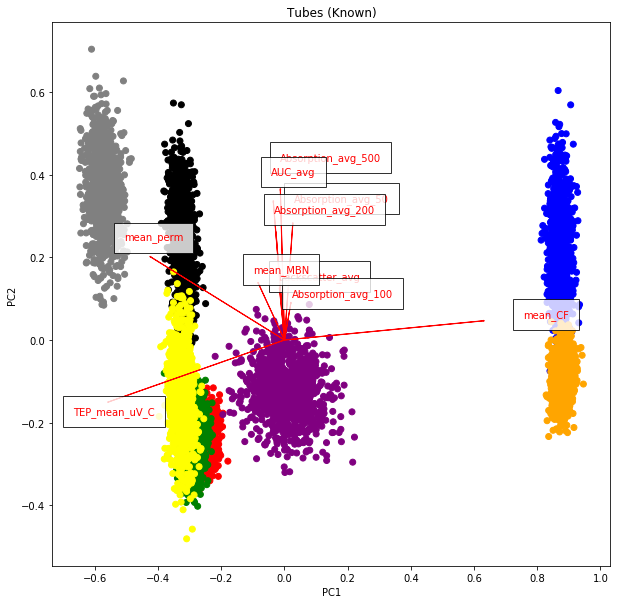

In [5]:
pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(scaled_known)

color_dict = { 'T_AR':'red', 'T_N':'blue', 'T_N_T':'black', 'T_T':'green','T_OT':'purple',
             'T_FF':'grey', 'T_HAZ':'orange', 'T_HAZ_T':'yellow' }

mc.biplot(pca, scaled_known, 0, 1, "Tubes (Known)", color_dict)

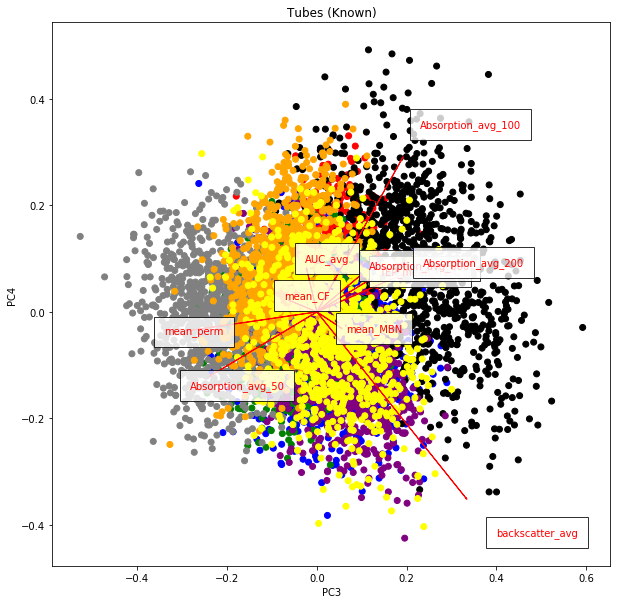

In [6]:
mc.biplot(pca, scaled_known, 2, 3, "Tubes (Known)", color_dict)

Next we repeat for the unknown tubes. Since we're doing the PCA again it's possible that the components change but the variation should generally be in similar features and it should give us a general indication. In fact, the first two components look extremely similar and from this there seems to be 3 samples that cannot be told apart, but there are possible identifications for the others. Of the blind microstructure samples that were identified based on a single measurement in the previous reports, 4 are identified using this method, 1 additional sample is potentially identified, and one previously identified sample could not be identified. But is should be noted that this is based on the first two principal components alone so a full  model would presuably have more power.

In agreement with previous reports:
* FF=B7
* OT=B8
* N=B4
* HAZ=B6

Identified in previous report but not here:
* AR=B5

Identified here but not in previous reports:
* N_T=B2

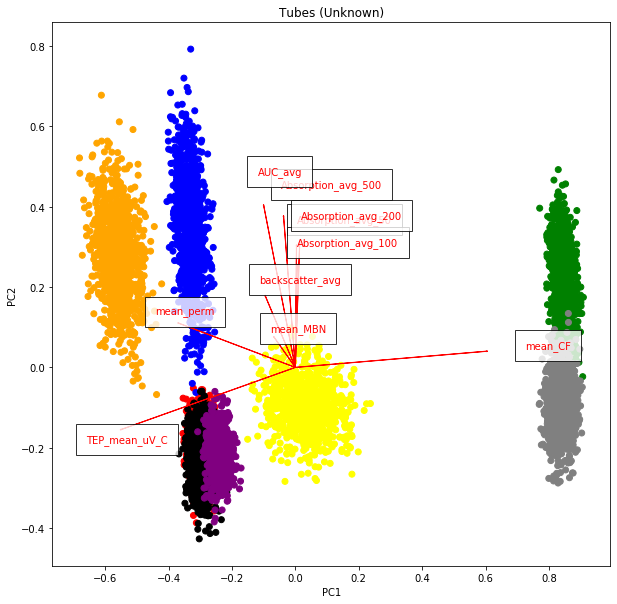

In [7]:
df_unknown = df.iloc[:8000,]
scaled_unknown = mc.scale_general(df_unknown, MinMaxScaler())[0]

pca = PCA(n_components=0.9, svd_solver='full')
pca.fit(scaled_unknown)

color_dict = { 'T_B1':'red', 'T_B2':'blue', 'T_B3':'black', 'T_B4':'green','T_B5':'purple',
             'T_B6':'grey', 'T_B7':'orange', 'T_B8':'yellow' }

mc.biplot(pca, scaled_unknown, 0, 1, "Tubes (Unknown)", color_dict)

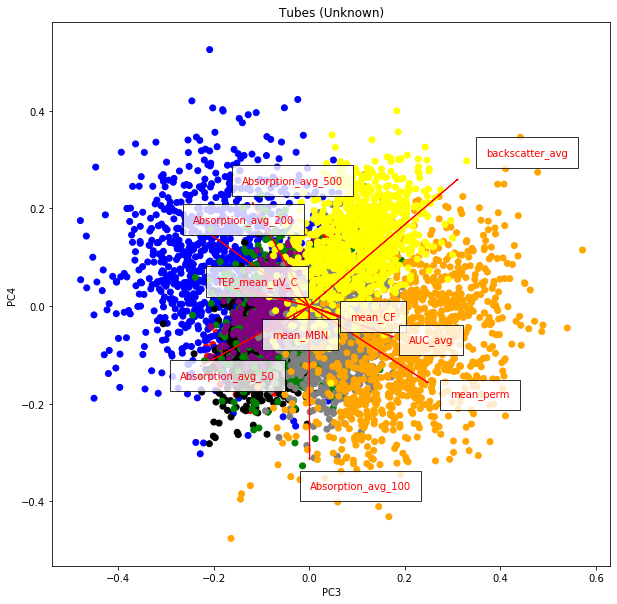

In [8]:
mc.biplot(pca, scaled_unknown, 2, 3, "Tubes (Unknown)", color_dict)

# Clustering

## Elbow method

In [9]:
min_range = 2
max_range = 8

def plot_elbow_kmeans(feat_norm, title):
    '''
    Elbow plot
    Args:
    - feat_norm : pandas dataframe
    - title : title of the figure ideally correpond to the samples
    return plot
    '''
    
    inertia = []
    k_list = range(min_range, max_range+1)

    for k in k_list:
        km = KMeans(n_clusters = k, random_state= 0)
        km.fit(feat_norm) 
        score = km.inertia_
        inertia.append(score)


    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(min_range , max_range+1) , inertia , 'o')
    plt.plot(np.arange(min_range , max_range+1) , inertia , '-' , alpha = 0.5)

    plt.xlabel('Number of Clusters', fontsize=20) , plt.ylabel('Inertia', fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

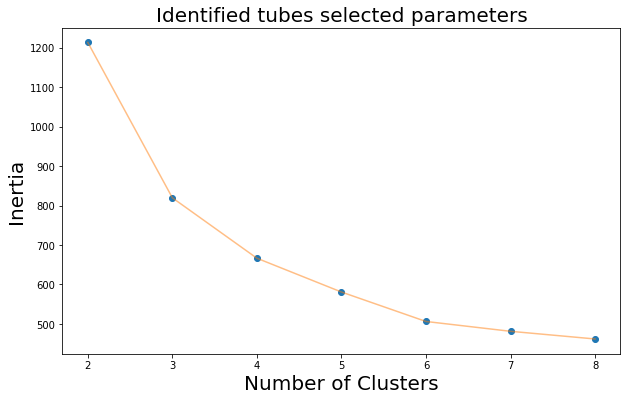

In [10]:
plot_elbow_kmeans(scaled_known, title='Identified tubes selected parameters')

## Auto find K
Source: https://jtemporal.com/kmeans-and-elbow-method/

In [11]:
def calculate_wcss(data):
    '''
    Calculate within class sum-squared value which represents loss in KMeans clustering
    '''
    wcss = []
    for n in range(min_range, max_range):
        kmeans = KMeans(n_clusters=n,random_state=0)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    
    return wcss

from math import sqrt

def optimal_number_of_clusters(wcss):
    '''
    Calculate normal distance 
    '''
    x1, y1 = min_range, wcss[0]
    x2, y2 = max_range, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2
    

In [12]:
# calculating the within clusters sum-of-squares for n cluster amounts
sum_of_squares = calculate_wcss(scaled_known)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares)
print('Number of cluster =', n)

Number fo cluster = 4


In [13]:
def plot_kmeans(df, k, range_col):
    '''
    Scatter plot
    Args:
    - df : scaled pandas dataframe
    - range_col : np.r_[range of column wanted]
    return plot
    '''
    model = KMeans(n_clusters = k, random_state= 42)
    model.fit(df) 
    labels = model.predict(df)
    print(labels)
    df['labels'] = labels
    sns.pairplot(df.iloc[:, range_col], hue='labels')

[3 3 3 ... 1 3 3]


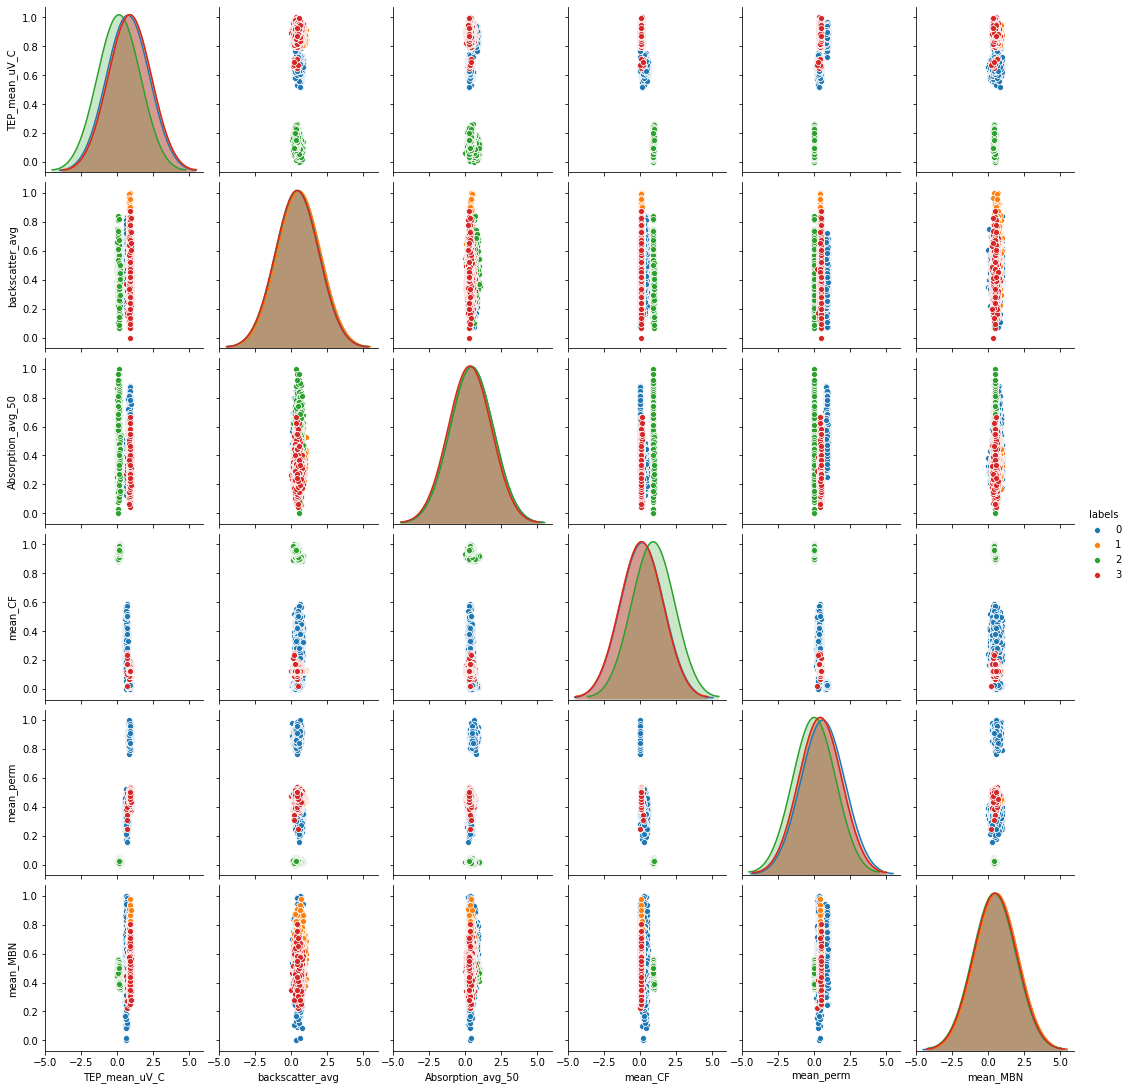

In [15]:
plot_kmeans(scaled_known, 4, np.r_[0, 2:4, 6:9,-1] )

With the k-means clustering algorithm it is proposed that the best k is 4. From the PCA it is clear that there are already at least 6 clusters that can be identified clearly from the first 2 components alone. From the distribution it is clear that the clusters are not symmetric so k-means is not good for this dataset.